# Robust Neural Network: 2D toy example

In this example, we train a simple network that is robust to adversarial noise. 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import seaborn
import matplotlib.patches as patches
from scipy.spatial import HalfspaceIntersection

%matplotlib inline
seaborn.set(font_scale=2)
seaborn.set_style("white")

import numpy as np

In [2]:
# random points at least 2r apart
m = 13
np.random.seed(3)
x = [np.random.uniform(size=(2))]
r = 0.16
while(len(x) < m):
    p = np.random.uniform(size=(2))
    if min(np.abs(p-a).sum() for a in x) > 2*r:
        x.append(p)

epsilon = r/2

X = torch.Tensor(np.array(x))
torch.manual_seed(1)
y = (torch.rand(m)+0.5).long()

## Baseline: cross entropy loss

In [4]:
net = nn.Sequential(
    nn.Linear(2,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,2)
)

opt = optim.Adam(net.parameters(), lr=1e-3)
for i in range(1000):
    out = net(Variable(X))
    l = nn.CrossEntropyLoss()(out, Variable(y))
    err = (out.max(1)[1].data != y).float().mean()
    if i % 100 == 0:
        print(l.item(), err)
    opt.zero_grad()
    (l).backward()
    opt.step()
print(l.item())

0.6862021684646606 tensor(0.3846)
0.1879635453224182 tensor(0.0769)
0.0037438501603901386 tensor(0.)
0.0009803588036447763 tensor(0.)
0.0004676672106143087 tensor(0.)
0.0002772808074951172 tensor(0.)
0.00018409582844469696 tensor(0.)
0.00013091013533994555 tensor(0.)
9.806339221540838e-05 tensor(0.)
7.598217052873224e-05 tensor(0.)
6.0705038777086884e-05


### Visualization: learned baseline classifier 

/home/tako/anaconda3/envs/lsy/lib/python3.6/site-packages/torch/tensor.py:263: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


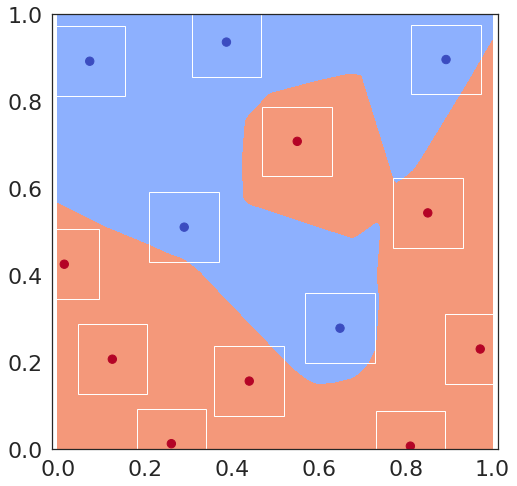

In [5]:
XX, YY = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
X0 = Variable(torch.Tensor(np.stack([np.ravel(XX), np.ravel(YY)]).T))
y0 = net(X0)
ZZ = (y0[:,0] - y0[:,1]).resize(100,100).data.numpy()

fig, ax = plt.subplots(figsize=(8,8))
ax.contourf(XX,YY,-ZZ, cmap="coolwarm", levels=np.linspace(-1000,1000,3))
ax.scatter(X.numpy()[:,0], X.numpy()[:,1], c=y.numpy(), cmap="coolwarm", s=70)
ax.axis("equal")
ax.axis([0,1,0,1])

for a in x:
    ax.add_patch(patches.Rectangle((a[0]-r/2, a[1]-r/2), r, r, fill=False))

In [6]:
import copy

In [7]:
def absolutify(layer):
    layer_ = copy.deepcopy(layer)
    layer_.weight = torch.nn.Parameter(torch.abs(layer_.weight))
    layer_.bias = torch.nn.Parameter(torch.zeros_like(layer_.bias[:]))
    return layer_

In [8]:
def net_IBP(net_eval_, x_, eps_):
    eps1 = eps_*torch.ones_like(x_)
    
    mu_list = []
    r_list = []
    
    mu = x_
    r = eps1
    
    mu_list.append(mu)
    r_list.append(r)
    
    for i, layer in enumerate(net_eval_.modules()):
        if i==0:
            pass
        else:
            if layer.__class__.__name__=='Conv2d' or layer.__class__.__name__=='Linear':
                mu = layer.forward(mu)
                layer_ = absolutify(layer)
                r = layer_.forward(r)
            elif layer.__class__.__name__=='ReLU': ####################
                mu_ = (layer.forward(mu+r)+layer.forward(mu-r))/2
                r = (layer.forward(mu+r)-layer.forward(mu-r))/2
                mu = mu_
            elif layer.__class__.__name__=='Flatten':
                mu = layer.forward(mu)
                r = layer.forward(r)

            else:
                print('DEBUGGING')
            mu_list.append(mu)
            r_list.append(r)
    return mu, r, mu_list, r_list

In [9]:
def logit_IBP(mu,r,onehot_y):
    return mu+r-2*r*onehot_y

In [10]:
def one_hot(batch,depth=10):
    ones = torch.eye(depth).cuda()
    return ones.index_select(0,batch)

## Robust Neural Network

In [11]:
X

tensor([[0.5508, 0.7081],
        [0.2909, 0.5108],
        [0.8929, 0.8963],
        [0.1256, 0.2072],
        [0.6491, 0.2785],
        [0.4405, 0.1569],
        [0.3880, 0.9364],
        [0.9716, 0.2306],
        [0.8510, 0.5436],
        [0.0736, 0.8924],
        [0.0151, 0.4256],
        [0.8109, 0.0073],
        [0.2613, 0.0129]])

In [12]:
y

tensor([1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1])

In [53]:
robust_net = nn.Sequential(
    nn.Linear(2,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,2)
)
robust_net_cuda = robust_net.cuda()
X = X.cuda()
y = y.cuda()

In [54]:
niters = 10000

In [55]:
data = []
opt = optim.Adam(robust_net.parameters(), lr=0.001)
onehot_y = one_hot(y, 2)
eps_=0
kappa =1
save_eps = 0
l_robust = 0

for i in range(niters):
    out = robust_net(X)
    l2 = nn.CrossEntropyLoss()(out, Variable(y))
    err = (out.max(1)[1].data != y).float().mean()
    
    if i>1000 and l_robust<0.01: ### eps이 바뀌면서 갑자기 확 못하게 되면 eps를 그대로 유지시키면서 조금 더 training
        eps_ += 1/niters*epsilon#i/niters*epsilon
        kappa -= 1/niters*0.5#1-i/niters*0.5
    elif l_robust>0.01:
        print('.', end='')
        
    mu, rr, _, _ = net_IBP(robust_net, X, eps_)
    worst_logit = logit_IBP(mu, rr, onehot_y)
    l_robust = nn.CrossEntropyLoss()(worst_logit, Variable(y))
    robust_err = (worst_logit.max(1)[1].data != y).float().mean()
    
    if i<1000:
        loss = l2
    else:
        loss = kappa*l2+(1-kappa)*l_robust

    if i % 100 == 0: ### print loss/err
        print('eps: %.5f, l: %.5f, l_robust: %.5f, err: %.5f, err_robust: %.5f'%(eps_, l2.item(), l_robust.item(), err.item(), robust_err.item()))
        data.append([l2, l_robust, err, robust_err])    
        
    if err<0.01 and robust_err<0.01 and eps_>0.4*epsilon: ### stopping criterion
        print('enough')
        break
        
    opt.zero_grad()
    (loss).backward()
    opt.step()

eps: 0.00000, l: 0.68274, l_robust: 0.68274, err: 0.38462, err_robust: 0.38462
....................................................................................................eps: 0.00000, l: 0.04577, l_robust: 0.04577, err: 0.00000, err_robust: 0.00000
.................eps: 0.00000, l: 0.00081, l_robust: 0.00081, err: 0.00000, err_robust: 0.00000
eps: 0.00000, l: 0.00031, l_robust: 0.00031, err: 0.00000, err_robust: 0.00000
eps: 0.00000, l: 0.00017, l_robust: 0.00017, err: 0.00000, err_robust: 0.00000
eps: 0.00000, l: 0.00010, l_robust: 0.00010, err: 0.00000, err_robust: 0.00000
eps: 0.00000, l: 0.00007, l_robust: 0.00007, err: 0.00000, err_robust: 0.00000
eps: 0.00000, l: 0.00005, l_robust: 0.00005, err: 0.00000, err_robust: 0.00000
eps: 0.00000, l: 0.00004, l_robust: 0.00004, err: 0.00000, err_robust: 0.00000
eps: 0.00000, l: 0.00003, l_robust: 0.00003, err: 0.00000, err_robust: 0.00000
eps: 0.00000, l: 0.00003, l_robust: 0.00003, err: 0.00000, err_robust: 0.00000
eps: 0.00080, 

In [56]:
X.size(), y.size(), mu.size(), rr.size(), onehot_y.size(), worst_logit.size(), out.size()

(torch.Size([13, 2]),
 torch.Size([13]),
 torch.Size([13, 2]),
 torch.Size([13, 2]),
 torch.Size([13, 2]),
 torch.Size([13, 2]),
 torch.Size([13, 2]))

### Visualization: learned robust classifier

/home/tako/anaconda3/envs/lsy/lib/python3.6/site-packages/torch/tensor.py:263: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


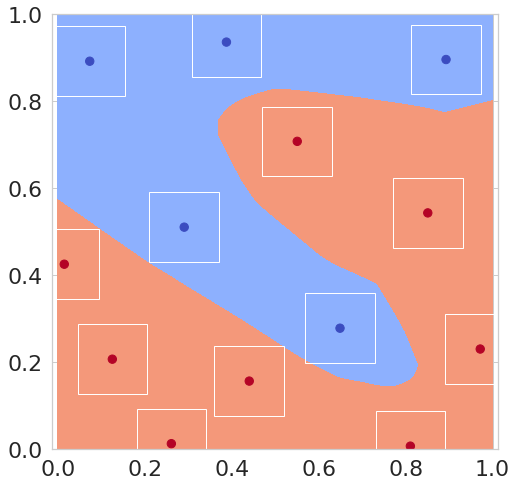

In [57]:
XX, YY = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
X0 = Variable(torch.Tensor(np.stack([np.ravel(XX), np.ravel(YY)]).T))
y0 = robust_net.cpu()(X0)
ZZ = (y0[:,0] - y0[:,1]).resize(100,100).data.numpy()

fig, ax = plt.subplots(figsize=(8,8))
ax.contourf(XX,YY,-ZZ, cmap="coolwarm", levels=np.linspace(-1000,1000,3))
ax.scatter(X.cpu().numpy()[:,0], X.cpu().numpy()[:,1], c=y.cpu().numpy(), cmap="coolwarm", s=70)
ax.axis("equal")
ax.axis([0,1,0,1])

for a in x:
    ax.add_patch(patches.Rectangle((a[0]-r/2, a[1]-r/2), r, r, fill=False))

# Grid plots

In [58]:
def plot_grid(net, ax): 
    XX, YY = np.meshgrid(np.linspace(-0.1, 1.1, 100), np.linspace(-0.1, 1.1, 100))
    X0 = Variable(torch.Tensor(np.stack([np.ravel(XX), np.ravel(YY)]).T))
    y0 = net(X0)
    ZZ = (y0[:,0] - y0[:,1]).resize(100,100).data.numpy()

    ax.contourf(XX,YY,-ZZ, cmap="coolwarm", levels=np.linspace(-1000,1000,3))
    ax.scatter(X.cpu().numpy()[:,0], X.cpu().numpy()[:,1], c=y.cpu().numpy(), cmap="coolwarm", s=70)
    ax.axis("equal")
    ax.axis([0,1,0,1])

    for a in x:
        ax.add_patch(patches.Rectangle((a[0]-r/2, a[1]-r/2), r, r, fill=False))
    ax.set_yticks([0.0, 0.5, 1.0])
#     ax.set_xticks([])

/home/tako/anaconda3/envs/lsy/lib/python3.6/site-packages/torch/tensor.py:263: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/home/tako/anaconda3/envs/lsy/lib/python3.6/site-packages/torch/tensor.py:263: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


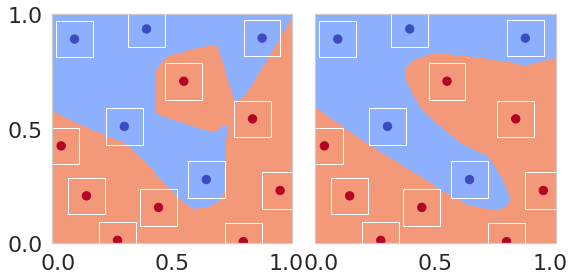

In [59]:
fig, axs = plt.subplots(1,2,figsize=(8,4), sharey=True)
plot_grid(net, axs[0])
plot_grid(robust_net, axs[1])
plt.tight_layout()
plt.savefig('2D_grid.pdf', bbox_inches='tight')

# Learning curves

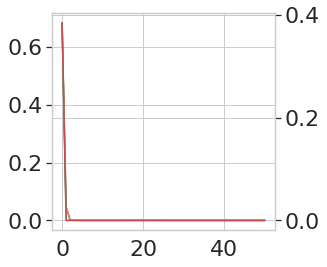

In [60]:
seaborn.set_style("whitegrid")
d = np.array(data)
fig, ax_loss = plt.subplots(1,1,figsize=(4,4))
ax_loss.plot(d[:,0], color='C0')
ax_loss.plot(d[:,1], color='C1')
ax_err = ax_loss.twinx()
ax_err.plot(d[:,2], color='C2')
ax_err.plot(d[:,3], color='C3')

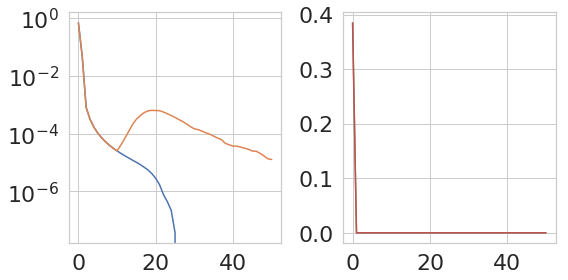

In [61]:
seaborn.set_style("whitegrid")
d = np.array(data)
fig, axs = plt.subplots(1,2,figsize=(8,4))
axs[0].semilogy(d[:,0], color='C0')
axs[0].semilogy(d[:,1], color='C1')
axs[1].plot(d[:,2], color='C2')
axs[1].plot(d[:,3], color='C3')
plt.tight_layout()
plt.savefig('2D_curves.pdf', bbox_inches='tight')

data.append([l2, l_robust, err, robust_err])    
왼쪽 plot은 처음 두개 오른쪽 plot은 다음 두개

In [93]:
y[0]

tensor(1, device='cuda:0')

In [63]:
X[0]

tensor([0.5508, 0.7081], device='cuda:0')

In [127]:
from matplotlib.patches import Rectangle


In [168]:
def show_ith_results(n):
    for i in range(200):
        delta = 2*epsilon*torch.rand(2)-epsilon
        sample = X[n]+delta.cuda()
        sample_out = robust_net_eval(sample)
        so_np = (sample_out.detach().cpu().numpy())
        plt.scatter(so_np[0], so_np[1], marker='.', c='black')
    mu, rr, _, _ = net_IBP(robust_net_eval, X[n], epsilon)

    mu_np = mu.detach().cpu().numpy()
    rr_np = rr.detach().cpu().numpy()


    plt.scatter(mu_np[0]+rr_np[0], mu_np[1]+rr_np[1])
    plt.scatter(mu_np[0]+rr_np[0], mu_np[1]-rr_np[1])
    plt.scatter(mu_np[0]-rr_np[0], mu_np[1]+rr_np[1])
    plt.scatter(mu_np[0]-rr_np[0], mu_np[1]-rr_np[1])
    plt.plot(np.arange(-100,100),np.arange(-100,100))
    
    rect = Rectangle((mu_np[0]-rr_np[0], mu_np[1]-rr_np[1]), 2*rr_np[0], 2*rr_np[1], fill=False, edgecolor='black')
    ax = plt.gca()
    ax.add_patch(rect)
    plt.title(y[n].detach().cpu().numpy())
    plt.show()

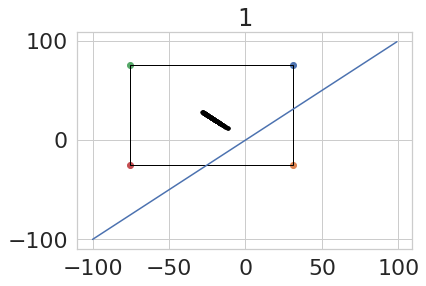

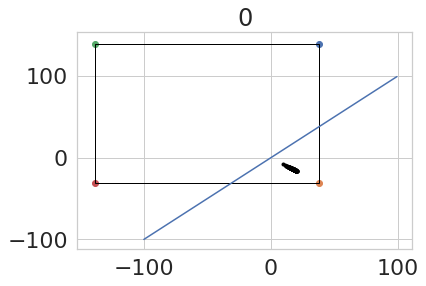

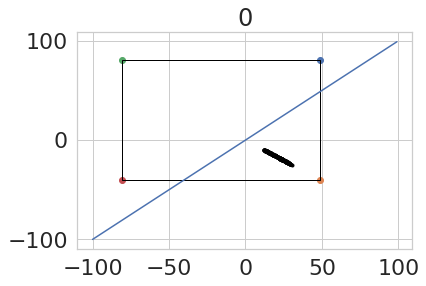

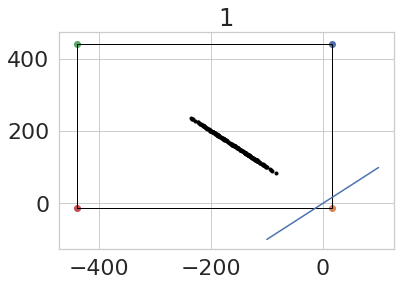

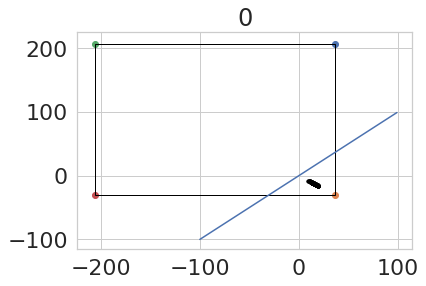

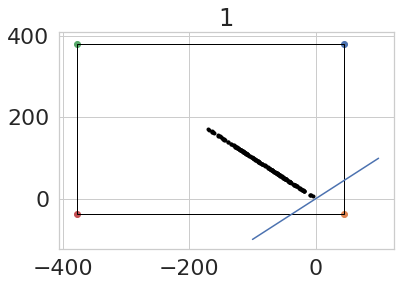

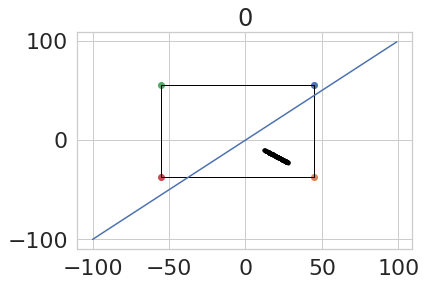

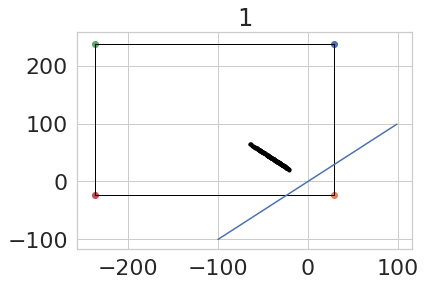

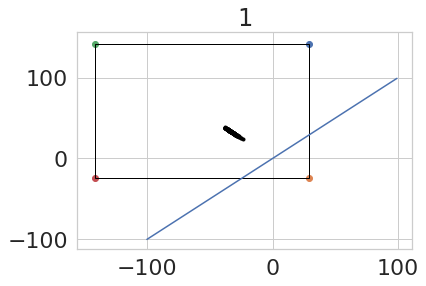

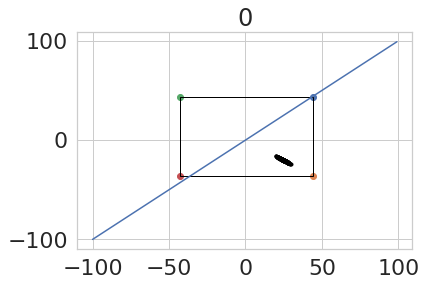

In [169]:
for i in range(10):
    show_ith_results(i)

In [113]:
net_eval = net.cuda().eval()

In [170]:
def show_ith_results_normal(n):
    for i in range(200):
        delta = 2*epsilon*torch.rand(2)-epsilon
        sample = X[n]+delta.cuda()
        sample_out = net_eval(sample)
        so_np = (sample_out.detach().cpu().numpy())
        plt.scatter(so_np[0], so_np[1], marker='.', c='black')
    mu, rr, _, _ = net_IBP(net_eval, X[n], epsilon)

    mu_np = mu.detach().cpu().numpy()
    rr_np = rr.detach().cpu().numpy()


    plt.scatter(mu_np[0]+rr_np[0], mu_np[1]+rr_np[1])
    plt.scatter(mu_np[0]+rr_np[0], mu_np[1]-rr_np[1])
    plt.scatter(mu_np[0]-rr_np[0], mu_np[1]+rr_np[1])
    plt.scatter(mu_np[0]-rr_np[0], mu_np[1]-rr_np[1])
    plt.plot(np.arange(-100,100),np.arange(-100,100))
    
    rect = Rectangle((mu_np[0]-rr_np[0], mu_np[1]-rr_np[1]), 2*rr_np[0], 2*rr_np[1], fill=False, edgecolor='black')
    ax = plt.gca()
    ax.add_patch(rect)
    plt.title(y[n].detach().cpu().numpy())
    plt.show()

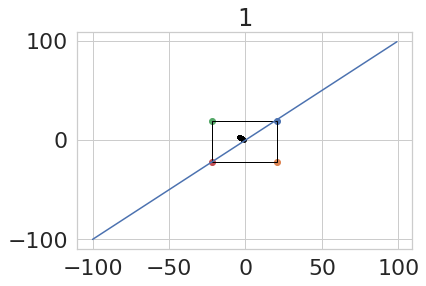

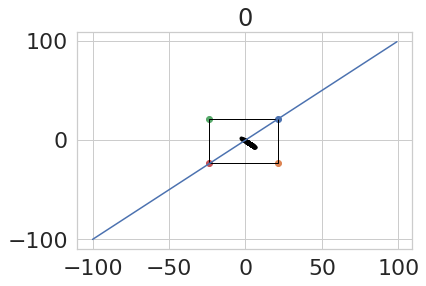

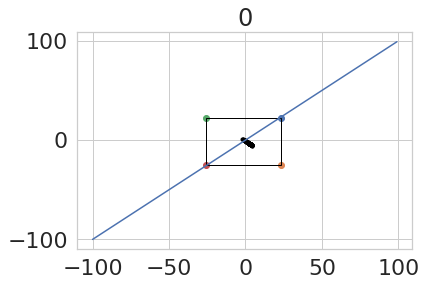

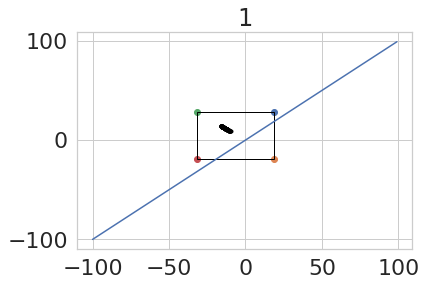

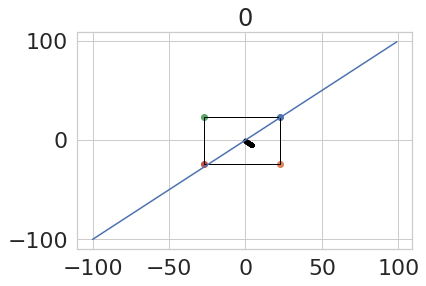

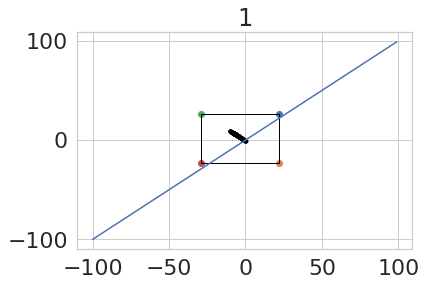

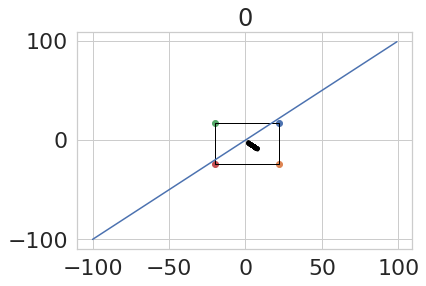

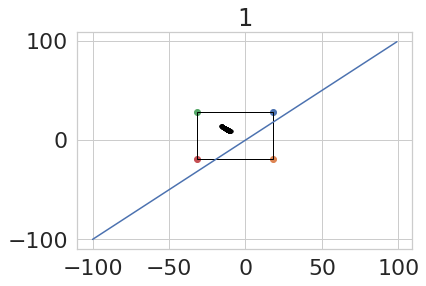

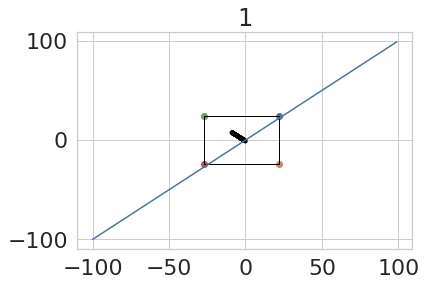

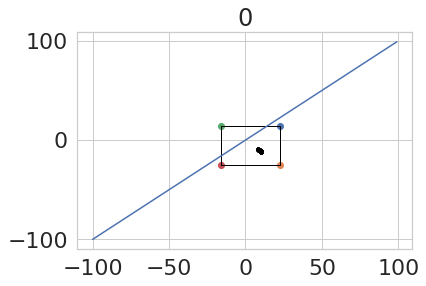

In [171]:
for i in range(10):
    show_ith_results_normal(i)